# Exploratory Data Analysis

In [36]:
#importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib import colors
import seaborn as sns
import geopandas as gpd
import pysal.lib as lps
from pysal.explore import esda
import spreg
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# defining a style
sns.set(style='darkgrid')
colors_arr = ['#1a96d0', '#fe9c39']

In [37]:
%load_ext extensions.skip

The extensions.skip extension is already loaded. To reload it, use:
  %reload_ext extensions.skip


In [38]:
# choose the spatial unit: neighborhood or hdu
spatial_unit = 'neighborhood'

## 1. Loading the data

This provided dataset is the one obtained after the data cleaning stage mentioned in the article *"A composite indicator of liveability based on sociodemographic and Uber quality service dimensions: a data-driven approach"*.

In [39]:
df = pd.read_csv("./data/uber_{}.csv".format(spatial_unit), index_col=0)

In [40]:
df.head()

,hdu_id,hdu_name,population,gini,life_exp,r_dep,rdpc,r_age,mhdi,mhdi_e,mhdi_l,mhdi_i,ETA_S_mean,ETA_X_mean,ETA_S_std,ETA_X_std,region,car_robbery
0,1240810200001,Tirol / Petropólis / Areia Preta,18999,0.54,81.01,38.86,4119.01,14.54,0.948,0.912,0.934,1.000,320.095582,237.762740,129.180420,94.910868,east,77.0
1,1240810200002,Mãe Luiza,14371,0.46,72.67,48.00,497.12,6.65,0.694,0.634,0.795,0.664,399.197485,305.917379,136.865062,114.999044,east,1.0
2,1240810200003,Areia Preta / Mãe Luiza / Petropólis,4799,0.54,80.16,39.26,2128.07,9.73,0.885,0.840,0.919,0.897,370.474026,278.658335,132.642034,103.676848,east,3.0
3,1240810200004,Lagoa Azul : Conjunto Parque das Dunas / Norde...,28567,0.37,69.36,47.50,336.00,3.66,0.637,0.581,0.739,0.601,498.702533,370.020611,126.143932,102.681371,north,60.0
4,1240810200005,Nossa Senhora da Apresentação : Loteamentos Po...,43331,0.43,69.18,51.04,316.29,3.42,0.615,0.534,0.736,0.591,482.908968,355.664244,129.971019,107.744746,north,116.0


In [41]:
df.shape

(58, 18)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 58
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hdu_id       58 non-null     int64  
 1   hdu_name     58 non-null     object 
 2   population   58 non-null     int64  
 3   gini         58 non-null     float64
 4   life_exp     58 non-null     float64
 5   r_dep        58 non-null     float64
 6   rdpc         58 non-null     float64
 7   r_age        58 non-null     float64
 8   mhdi         58 non-null     float64
 9   mhdi_e       58 non-null     float64
 10  mhdi_l       58 non-null     float64
 11  mhdi_i       58 non-null     float64
 12  ETA_S_mean   58 non-null     float64
 13  ETA_X_mean   58 non-null     float64
 14  ETA_S_std    58 non-null     float64
 15  ETA_X_std    58 non-null     float64
 16  region       58 non-null     object 
 17  car_robbery  58 non-null     float64
dtypes: float64(14), int64(2), object(2)
memory usage: 8.

## 2. Data Analysis

In [43]:
spatial_area_label = 'hdu_id' if spatial_unit == 'hdu' else 'neighborhood'

y_cols = ['ETA_X_mean', 'ETA_S_mean', 'ETA_X_std', 'ETA_S_std']
uber_eta = df[[spatial_area_label, 'region'] + y_cols]

### 2.1. Uber Services in the considered city

#### Mean and standard deviation
The means are represented by the small circles and the standard deviations by the whiskers, comparing the UberX (blue) and UberSelect (orange) services performance.

In [44]:
def plot_scatter(df, region, x, y, ax, err):
    legend_handles = []
    regional_df = df.xs(region).reset_index()
    
    for i, yi in enumerate(y):
        regional_df.plot(
            kind='scatter', y=yi, x=x, ax=ax, label=yi, color=colors_arr[i], fontsize=10.5, legend=(region == 'East')
        ).set_xlabel(region, weight='bold', fontsize=14)
        ax.errorbar(x=regional_df[x], y=regional_df[yi], yerr=regional_df[err[i]], color=colors_arr[i], fmt='o', capsize=2)
        ax.set_ylabel('ETA (seconds)')
        ax.xaxis.set_tick_params(rotation=90)
        
        if (region == 'East'):
            legend_handles.append(Line2D([0], [0], marker='o', color=colors_arr[i], label=yi + ' (μ ± σ)', markersize=6),)
            ax.legend(title='Service', handles=legend_handles)

In [45]:
# preparing the dataset to plot the mean and standard deviation
df_plot = uber_eta.copy()
df_plot.region = df_plot.region.str.capitalize()

# preprocessing the spatial label to plot
if spatial_area_label == 'hdu_id':
  df_plot[spatial_area_label] = df_plot[spatial_area_label].astype(str).str[-2:]
  df_plot[spatial_area_label] = df_plot[spatial_area_label].str.pad(5)
else:
  df_plot[spatial_area_label] = df_plot[spatial_area_label].str.replace('Nossa Senhora', 'N. S.')
  df_plot[spatial_area_label] = df_plot[spatial_area_label].str.rjust(22)

# setting the spatial cutouts as index and sorting the values
df_plot = df_plot.set_index(['region', spatial_area_label]).rename(columns={'ETA_S_mean':'Uber Select','ETA_X_mean': 'Uber X'})\
  .sort_values(by=['region','Uber Select', 'Uber X'], ascending=True)

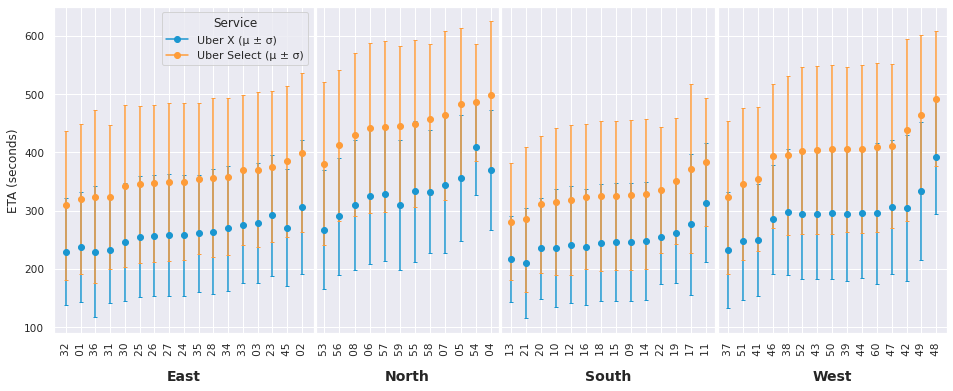

In [46]:
regions = df_plot.index.levels[0]
ratios = [len(df_plot.xs(region)) for region in regions]
fig, axes = plt.subplots(nrows=1, ncols=len(regions), sharey=True, figsize=(16, 6), gridspec_kw={'width_ratios': ratios})

for i, region in enumerate(regions):
    plot_scatter(df_plot, region, spatial_area_label, ['Uber X', 'Uber Select'], axes[i], err=['ETA_X_std', 'ETA_S_std'])

fig.subplots_adjust(wspace=0.01)

#### Choropleth maps
The colored spatial areas represent the magnitude of an associated variable, which is in this case the mean ETAs of the UberX and UberSelect.

In [47]:
# reading a shape file of Natal metropolitan region and filtering just the HDUs inside the city of Natal
file_path = 'shape/natal-hdu.shp' if spatial_unit == 'hdu' else 'geojson/natal-neighborhood.geojson'
gdf = gpd.read_file('./data/{}'.format(file_path))

if spatial_area_label == 'hdu_id':
  gdf = gdf[gdf['NM_MUNICIP'] == 'NATAL']
  gdf = gdf.rename(columns={'UDH_ATLAS': 'hdu_id'})
  gdf[spatial_area_label] = gdf[spatial_area_label].astype('int64')
else:
  gdf = gdf.rename(columns={'name': 'neighborhood'})

In [48]:
# joining spatial data to the ETA data
gdf = gdf.join(uber_eta.set_index(spatial_area_label), on=spatial_area_label, how='inner')
gdf.head(2)

,hdu_id,REGIONAL,CD_GEOCODM,NM_MUNICIP,geometry,region,ETA_X_mean,ETA_S_mean,ETA_X_std,ETA_S_std
65,1240810200001,324081003,2408102,NATAL,"POLYGON ((-35.20700 -5.79334, -35.20682 -5.793...",east,237.762740,320.095582,94.910868,129.180420
66,1240810200002,324081003,2408102,NATAL,"POLYGON ((-35.19391 -5.79061, -35.19387 -5.790...",east,305.917379,399.197485,114.999044,136.865062


In [49]:
def plot_choropleth_map(df, y, title, label, ax, cmap, vmin, vmax):
  ax.set_title(title, fontsize=20)
  ax.set_axis_off()
  df.plot(column=y, cmap=cmap, vmin=vmin, vmax=vmax, legend=False, ax=ax)
  df.apply(lambda x: ax.annotate(text=str(x[label]), xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1)

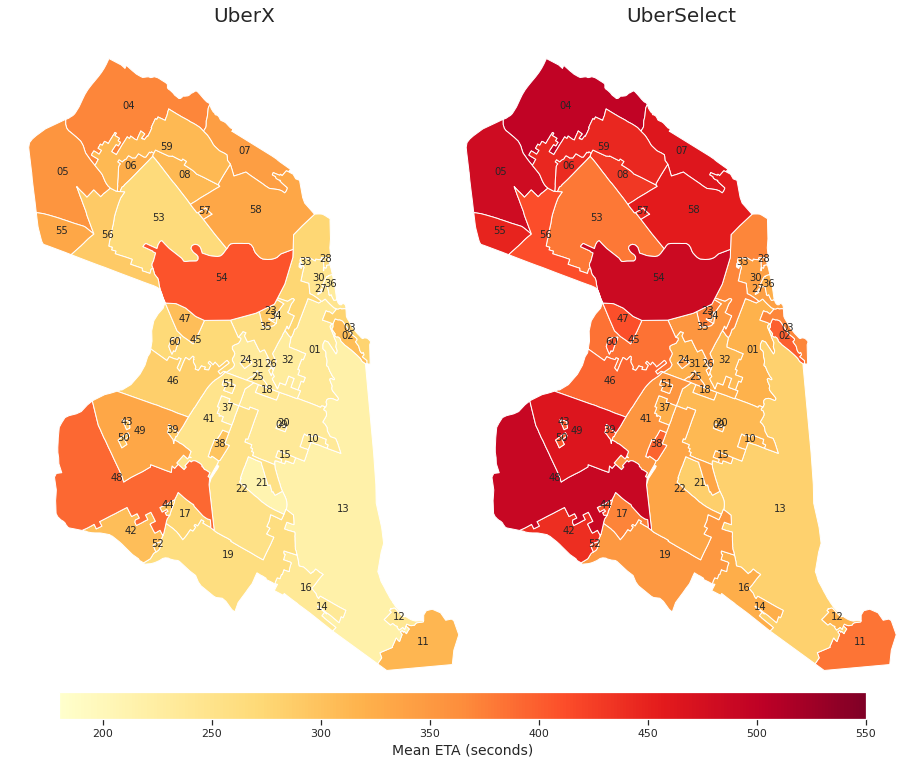

In [50]:
fig, ax = plt.subplots(1,2,figsize=(14,10))
y_cols = {'ETA_X_mean': 'UberX', 'ETA_S_mean': 'UberSelect'}
cmap = 'YlOrRd'
vmin, vmax = (180, 550)
if spatial_area_label == 'hdu_id':
  gdf[spatial_area_label] = gdf[spatial_area_label].astype(str).str[-2:]

for i, (y, title) in enumerate(y_cols.items()):
  plot_choropleth_map(gdf, y, title, spatial_area_label, ax[i], cmap, vmin, vmax)
    
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplots_adjust(left=0.1, right=0.9, bottom=-0.12, wspace=-0.3)
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15, aspect=30)
cbar.set_label('Mean ETA (seconds)', size=14)

plt.tight_layout()

#### Correlations

The Uber data were also correlated with some socioeconomic variables.

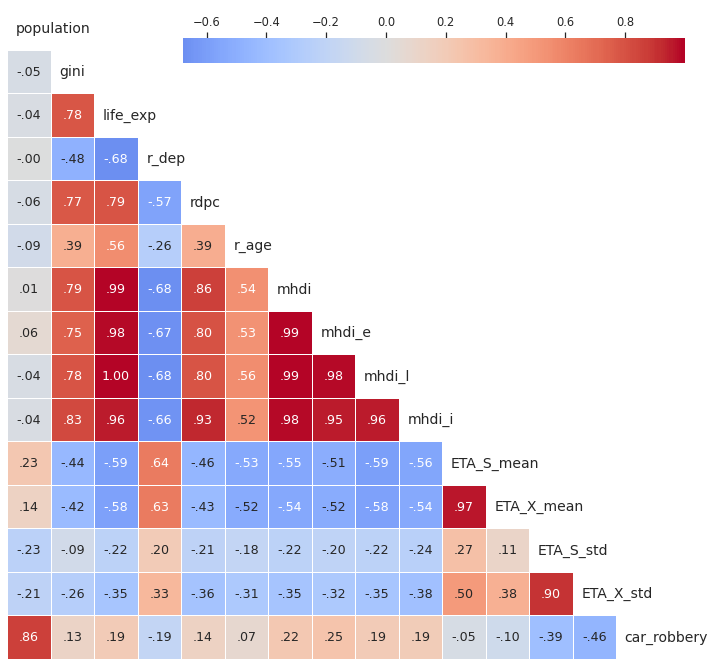

In [51]:
sns.set(style='white')

# Compute the correlation matrix and adjust the labels
corr = df.drop([spatial_area_label], axis='columns').corr()
corr_labels = [[re.sub('0(?=[.])', '', ("%.2f" % item)) for item in lists] for lists in corr.values]

# Configure the matplotlib figure
fig, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.05)
ax.tick_params(labelsize=14)
mask = np.triu(np.ones_like(corr)) #

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, cmap="coolwarm", center=0, annot=corr_labels, fmt="s", linewidths=.5, ax=ax, mask=mask,
    xticklabels=False, yticklabels=False, square=True,
    cbar_kws = dict(use_gridspec=False,location="top", shrink= 0.6, anchor=(0.8, -1))
)
bottom, top = ax.get_ylim()

# Write variable names
for i, label in enumerate(corr.index):
    ax.text(i + 0.2, i + 0.5, label, ha='left', va='center', fontsize=14)

### 2.2. Assessing the ETA significance

#### LISA Maps

To visualize the magnitude and significance of the spatial autocorrelation for each spatial cutout, cluster and significance maps known as LISA maps can be very useful. LISA means Local Indicators of Spatial Autocorrelation and it is a class of indicators that includes Moran's Local Index.

In [52]:
# Creating the weights matrix from the dataframe
w = lps.weights.Rook.from_dataframe(gdf)
w.transform = 'r' # row-standardized
y_cols = ['ETA_X_mean', 'ETA_S_mean']

# Standardizing the columns
scaler = StandardScaler()
y = scaler.fit_transform(gdf[y_cols])

In [53]:
def get_lisa_map_categories(y, w, type):
  moran_local = esda.moran.Moran_Local(y, w)

  if type == 'cluster':
    significance = 1 * (moran_local.p_sim < 0.05)
    hh = 1 * (significance * moran_local.q==1) # high-high
    lh = 2 * (significance * moran_local.q==2) # low-high
    ll = 3 * (significance * moran_local.q==3) # low-low
    hl = 4 * (significance * moran_local.q==4) # high-low
    spots = hh + ll + lh + hl
    spot_labels = [ 'Not significant', '1 High-High', '2 Low-High', '3 Low-Low', '4 High-Low']
    categories = [spot_labels[j] for j in spots]
    
  elif type == 'significance':
    # selecting significance level spots
    s = 1 * ((moran_local.p_sim >= 0.01) & (moran_local.p_sim < 0.05))   # significant
    vs = 2 * ((moran_local.p_sim >= 0.001) & (moran_local.p_sim < 0.01)) # very significant
    es = 3 * (moran_local.p_sim < 0.001)                                 # extremely significant
    spots = s + vs + es
    spot_labels = [ 'Not significant', '1 0.01 ≤ p < 0.05', '2 0.001 ≤ p < 0.01', '3 p < 0.001']
    categories = [spot_labels[j] for j in spots]

  return categories

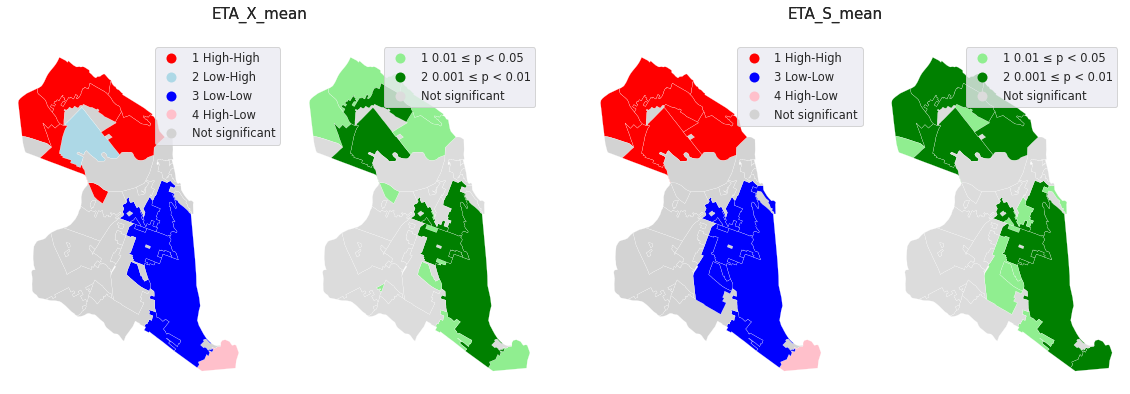

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 14))

colormap = {
    'Not significant': 'lightgrey',
    '1 High-High': 'red',
    '2 Low-High': 'lightblue',
    '3 Low-Low': 'blue',
    '4 High-Low': 'pink'
}
hmap = colors.ListedColormap(['red', 'lightblue', 'blue', 'pink', 'lightgrey'])
hmap_significance = colors.ListedColormap(['lightgreen', 'darkgreen', 'green', 'gainsboro'])

for i, col in enumerate(y_cols):
    cluster_categories = get_lisa_map_categories(y[:, i], w, 'cluster')
    significance_categories = get_lisa_map_categories(y[:, i], w, 'significance')
    
    # hmaps
    keys = list(set(cluster_categories))
    keys.sort()
    hmap = colors.ListedColormap([colormap[k] for k in keys])
    
    # ploting
    j = 0 if i % 2 == 0 else 2
    gdf.assign(cl=cluster_categories).plot(column='cl', categorical=True, \
        cmap=hmap, linewidth=0.2, ax=ax[i * 2], \
        edgecolor='white', legend=True, legend_kwds={'bbox_to_anchor':(1.15, 1)})
    gdf.assign(cl=significance_categories).plot(column='cl', categorical=True, \
        cmap=hmap_significance, linewidth=0.2, ax=ax[i * 2 + 1], \
        edgecolor='white', legend=True)
    
    plt.figtext(0.3,0.7,"ETA_X_mean", va="center", ha="center", size=15)
    plt.figtext(0.7,0.7,"ETA_S_mean", va="center", ha="center", size=15)
    
    ax[i * 2].set_axis_off()
    ax[i * 2 + 1].set_axis_off()

#### Regression Analysis

In [55]:
# adding new variables
if spatial_unit == 'neighborhood':
  df['car_crimes_rate'] = 100000*(df['car_theft'] + df['car_robbery'])/df['population']
  df['urban_services_ratio'] = 100000*(df['education_units'] + df['health_units'] + df['security_units'])/df['population']

# Defining X and y for regression
y_cols = ['ETA_X_mean', 'ETA_S_mean', 'ETA_X_std', 'ETA_S_std']

X_df = df.drop(labels=y_cols + [spatial_area_label],axis=1)
y_df = df[y_cols]

In [56]:
numeric_cols = list(X_df.select_dtypes(['float64', 'int64']).columns)

# Selecting numeric columns and standardizing the variables
X_prepared = X_df[numeric_cols]
scaler = StandardScaler()
X_prepared = scaler.fit_transform(X_prepared)

X_df = pd.DataFrame(X_prepared, columns = numeric_cols)
X_df.shape

(58, 11)

##### Feature selection and multicollinearity analysis

Feature selection uses `SelectKBest` from `sklearn`.

Variance Inflation Factor (VIF) is a measure of how much the variance of the coefficient derived from the model is inflated by collinearity. It helps detect multicollinearity that you cannot catch just by eyeballing a pairwise correlation plot and even detects strong relations between 3 variables and more.

Using these thechniques, let's search for the best k.

In [57]:
df_completed = pd.concat([X_df, y_df], axis=1)
# parameters
VIF = 5
k = 1
ols_results = {}


In [58]:
# searching fot the best k for each y
while(k <= X_df.shape[1]):
    # feature selection
    features = {}
    for uber_var in y_cols:
        fsel_model = SelectKBest(score_func=f_regression, k=k)
        fsel_model.fit_transform(X_df, y_df[uber_var])
        features[uber_var] = X_df.loc[:, fsel_model.get_support()].columns

    # multicollinearity analysis
    y, X = {}, {}
    selected_variables = {}
    for uber_var in y_cols:
        y[uber_var], X[uber_var] = dmatrices(uber_var + ' ~' + '+'.join(features[uber_var]), df_completed, return_type='dataframe')
        vif = [variance_inflation_factor(X[uber_var].values, x) < VIF for x in range(X[uber_var].shape[1])]
        selected_variables[uber_var] = [x for i, x in enumerate(X[uber_var].columns[1:]) if vif[1:][i]]

    # regression
    X = {}
    for uber_var in y_cols:
        X[uber_var] = X_df[selected_variables[uber_var]]
        ols = spreg.OLS(y_df[uber_var].values[:, None], X[uber_var].values)
        if k == 1:
            ols_results[uber_var] = { 'k': [k], 'r2': [ols.r2], 'aic': [ols.aic], 'mcn': [ols.mulColli] }
        else:
            ols_results[uber_var]['k'].append(k)
            ols_results[uber_var]['r2'].append(ols.r2)
            ols_results[uber_var]['aic'].append(ols.aic)
            ols_results[uber_var]['mcn'].append(ols.mulColli)

    k = k + 1

In [59]:
comparative = pd.concat([pd.DataFrame(ols_results[y]) for y in y_cols], axis = 1, keys=y_cols)

k_values = {}
for uber_var in y_cols:
    index = comparative[uber_var]['r2'].argmax()
    k_values[uber_var] = int(comparative[uber_var].loc[index].k)
    print('\n', uber_var, '\n', comparative[uber_var].loc[index])


 ETA_X_mean 
 k       10.000000
r2       0.548661
aic    562.093175
mcn      1.331189
Name: 9, dtype: float64

 ETA_S_mean 
 k       10.000000
r2       0.584936
aic    586.274308
mcn      1.331189
Name: 9, dtype: float64

 ETA_X_std 
 k        9.000000
r2       0.322381
aic    422.475377
mcn      1.387159
Name: 8, dtype: float64

 ETA_S_std 
 k        3.000000
r2       0.206827
aic    442.840889
mcn      4.074052
Name: 2, dtype: float64


Finally selecting the best features for each model:

In [60]:
features = {}
y, X = {}, {}
selected_variables = {}

for uber_var, k in k_values.items():
    # feature selection
    fsel_model = SelectKBest(score_func=f_regression, k=k)
    fsel_model.fit_transform(X_df, y_df[uber_var])
    features[uber_var] = X_df.loc[:, fsel_model.get_support()].columns

    # multicollinearity analysis
    y[uber_var], X[uber_var] = dmatrices(uber_var + ' ~' + '+'.join(features[uber_var]), df_completed, return_type='dataframe')
    vif = [variance_inflation_factor(X[uber_var].values, i) < VIF for i in range(X[uber_var].shape[1])]
    selected_variables[uber_var] = [v for i, v in enumerate(X[uber_var].columns[1:]) if vif[1:][i]]

In [61]:
selected_variables

{'ETA_X_mean': ['population', 'r_dep', 'r_age'],
 'ETA_S_mean': ['population', 'r_dep', 'r_age'],
 'ETA_X_std': ['r_dep', 'r_age', 'car_robbery'],
 'ETA_S_std': ['population', 'mhdi_i', 'car_robbery']}

##### OLS Regression


In [62]:
# taking logarithmic transformation of y
y = np.log(y_df)

# getting x variables
X = {}
for uber_var in y_cols:
    X[uber_var] = X_df[selected_variables[uber_var]]

In [63]:
for uber_var in y_cols:
    print(X[uber_var].skew())

population    1.383524
r_dep        -0.043606
r_age         0.896131
dtype: float64
population    1.383524
r_dep        -0.043606
r_age         0.896131
dtype: float64
r_dep         -0.043606
r_age          0.896131
car_robbery    1.311060
dtype: float64
population     1.383524
mhdi_i         0.796283
car_robbery    1.311060
dtype: float64


In [64]:
ols = {}
for uber_var in y_cols:
    ols[uber_var] = spreg.OLS(y[uber_var].values[:, None], X[uber_var].values, \
                  w=w, spat_diag=True, moran=True, \
                  name_x=X[uber_var].columns.tolist(), name_y='ln(' + uber_var + ')')
    print(ols[uber_var].summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ln(ETA_X_mean)                Number of Observations:          58
Mean dependent var  :      5.6258                Number of Variables   :           4
S.D. dependent var  :      0.1480                Degrees of Freedom    :          54
R-squared           :      0.5647
Adjusted R-squared  :      0.5405
Sum squared residual:       0.544                F-statistic           :     23.3477
Sigma-square        :       0.010                Prob(F-statistic)     :   8.017e-10
S.E. of regression  :       0.100                Log likelihood        :      53.134
Sigma-square ML     :       0.009                Akaike info criterion :     -98.267
S.E of regression ML:      0.0968                Schwarz criterion     :     -90.025

---------------------------------------------------------------------------

##### Spatial Regression


In [65]:
# As the residuals presented spatial dependence only for the HDU dataset, we can skip the following steps for the neighborhood dataset
skip_cell = spatial_unit == 'neighborhood'

In [66]:
%%skip $skip_cell
lag = {}
for uber_var in y_cols:
    lag[uber_var] = spreg.ML_Lag(y[uber_var].values[:, None], X[uber_var].values, w=w,  \
                  name_x=X[uber_var].columns.tolist(), name_y='ln(' + uber_var + ')')
    print(lag[uber_var].summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ln(ETA_X_mean)                Number of Observations:          58
Mean dependent var  :      5.6258                Number of Variables   :           5
S.D. dependent var  :      0.1480                Degrees of Freedom    :          53
Pseudo R-squared    :      0.6528
Spatial Pseudo R-squared:  0.6365
Sigma-square ML     :       0.007                Log likelihood        :      58.711
S.E of regression   :       0.086                Akaike info criterion :    -107.421
                                                 Schwarz criterion     :     -97.119

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------

The sum of squared residuals:

In [67]:
%%skip $skip_cell

for i, uber_var in enumerate(y_cols):
    print(uber_var, lag[uber_var].utu)

ETA_X_mean 0.4337807356919826
ETA_S_mean 0.295772414968717
ETA_X_std 0.388506846211628
ETA_S_std 0.34371021884155545


Moran's Index of the residuals:

In [68]:
%%skip $skip_cell

for i, uber_var in enumerate(y_cols):
    mi = esda.moran.Moran(lag[uber_var].u, w)
    print(uber_var, mi.I, mi.p_norm)

ETA_X_mean -0.052008212509075336 0.724348922626852
ETA_S_mean -0.07317132043828163 0.5692192933622513
ETA_X_std -0.06481269084866376 0.6286180037598518
ETA_S_std -0.07345935513848505 0.5672210734505618


**Impact measures**

Direct (local), indirect (spill-over), and total effect of a unit change in each of the predictor variables:

In [69]:
%%skip $skip_cell

I = np.identity(w.n)
W = w.full()[0]
impacts = []

for i, uber_var in enumerate(y_cols):
    impacts.append(pd.DataFrame(columns=['direct', 'indirect', 'total'], index=lag[uber_var].name_x[1:-1]))
    matrix = np.matmul(np.linalg.inv(I - lag[uber_var].rho * W), np.identity(w.n))
    for j, beta in enumerate(lag[uber_var].betas[1:-1]):
        Sr = matrix * beta
        index = impacts[i].index[j]
        impacts[i].loc[index] = [
            (1/w.n) * np.trace(Sr),
            (1/w.n) * np.sum(Sr) - (1/w.n) * np.trace(Sr),
            (1/w.n) * np.sum(Sr)
        ]

In [70]:
%%skip $skip_cell

for i, uber_var in enumerate(y_cols):
    print('\n', uber_var)
    print(impacts[i])
    print('--------------------------------------------------')


 ETA_X_mean
              direct  indirect     total
population  0.000022  0.000012  0.000034
r_dep        0.06902  0.038923  0.107942
r_age      -0.038131 -0.021503 -0.059635
--------------------------------------------------

 ETA_S_mean
              direct  indirect     total
population  0.006896  0.006248  0.013144
r_dep       0.058958  0.053413  0.112371
r_age      -0.030731 -0.027841 -0.058571
--------------------------------------------------

 ETA_X_std
               direct  indirect     total
r_dep        0.013773  0.004646  0.018419
r_age       -0.015766 -0.005319 -0.021085
car_robbery -0.050013 -0.016872 -0.066885
--------------------------------------------------

 ETA_S_std
               direct  indirect     total
population   0.026699  0.011344  0.038043
mhdi_i      -0.003037 -0.001291 -0.004328
car_robbery -0.062352 -0.026493 -0.088845
--------------------------------------------------
